Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 249ms/step - loss: 0.1188
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 239ms/step - loss: 0.0668
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - loss: 0.0499
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - loss: 0.0451
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - loss: 0.0403
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


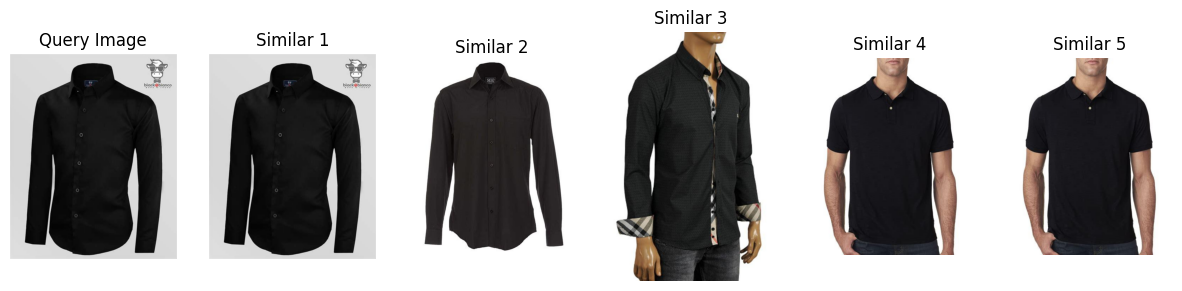

In [10]:
import os
import numpy as np
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



class ImageRetrievalModel:
    def __init__(self, input_shape=(128, 128, 3), embedding_dim=64):
        self.input_shape = input_shape
        self.embedding_dim = embedding_dim
        self.autoencoder, self.encoder = self._build_autoencoder()
        self.neighbor_model = None
        self.image_paths = []
        self.images = []

    def _build_autoencoder(self):
        # Encoder
        input_img = Input(shape=self.input_shape)
        x = Flatten()(input_img)
        encoded = Dense(256, activation='relu')(x)
        encoded = Dense(128, activation='relu')(encoded)
        
        # Decoder
        x = Dense(256, activation='relu')(encoded)
        x = Dense(np.prod(self.input_shape), activation='sigmoid')(x)
        decoded = Reshape(self.input_shape)(x)

        # Autoencoder
        autoencoder = Model(input_img, decoded)
        encoder = Model(input_img, encoded)  # Extract encoder separately
        autoencoder.compile(optimizer=Adam(0.001), loss='mse')

        return autoencoder, encoder

    def load_images_from_folder(self, folder_path):
        images = []
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path).resize(self.input_shape[:2]).convert('RGB')
                img_array = img_to_array(img) / 255.0
                images.append(img_array)
                self.image_paths.append(img_path)
            except Exception as e:
                print(f"Error loading image {filename}: {e}")
        self.images = np.array(images)

    def fit(self, dataset_path, batch_size=32, epochs=5):
        self.load_images_from_folder(dataset_path)

        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        self.autoencoder.fit(
            self.images, self.images,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            callbacks=[early_stopping]
        )

        encoded_features = self.encoder.predict(self.images)
        feature_vectors = encoded_features / np.linalg.norm(encoded_features, axis=1, keepdims=True)
        self.neighbor_model = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='cosine').fit(feature_vectors)

    
    def retrieve_similar_images(self, image_path, top_n=5):
        if self.neighbor_model is None:
            raise Exception("Model has not been fitted yet.")

        query_image = Image.open(image_path).resize(self.input_shape[:2]).convert('RGB')
        query_image_array = img_to_array(query_image) / 255.0
        query_image_array = np.expand_dims(query_image_array, axis=0)
        query_features = self.encoder.predict(query_image_array)
        query_features_normalized = query_features / np.linalg.norm(query_features)

        distances, indices = self.neighbor_model.kneighbors(query_features_normalized)
        similar_image_paths = [self.image_paths[idx] for idx in indices[0]]
        similar_images = [Image.open(img_path) for img_path in similar_image_paths]
        similar_images_arrays = [np.array(img) for img in similar_images]

        return similar_images_arrays

# Initialize and fit the model
dataset_path = "C:/Users/Rajesh R/Desktop/similarity/Apparel images dataset new/black_shirt"
model = ImageRetrievalModel()
model.fit(dataset_path)

# Test the model with a test image
test_image_path = "C:/Users/Rajesh R/Desktop/similarity/Apparel images dataset new/black_shirt/1a5c9dc36725668a6cb4ab6deddf5f0228596b61.jpg"
similar_images = model.retrieve_similar_images(test_image_path)

# Display the similar images
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 6, 1)
plt.imshow(Image.open(test_image_path))
plt.title("Query Image")
plt.axis('off')

for i, img in enumerate(similar_images):
    plt.subplot(1, 6, i + 2)
    plt.imshow(img)
    plt.title(f"Similar {i + 1}")
    plt.axis('off')

plt.show()

In [16]:
# Save the model weights
model=ImageRetrievalModel()
model.autoencoder.save_weights('autoencoder.weights.h5')
model.encoder.save_weights('encoder.weights.h5')